In [1]:
from brian2 import *
%matplotlib inline
import os,random

In [2]:
sim_time = 400 * ms
time_step = 0.001 * ms
defaultclock.dt = time_step
num_neurons = 34 * 34
n_of_m = 100
file_loc = "D://Download/N-MNIST/Train/"
time_dur = []
spike_digits = []
tot_spike_index = []
tot_spike_time = []
iterations = 3
accu_time = 0


for z in range(iterations):
    digit = random.choice(os.listdir(file_loc))
    Bytes = numpy.fromfile(file_loc+'/'+digit+'/'+random.choice(os.listdir(file_loc+'/'+digit)), dtype = "uint8")
    spike_digits.append(int(digit))
    Bits = numpy.unpackbits(Bytes)
    Bits = Bits.reshape(int(len(Bits)/40), 40)

    counter_n = 0
    spike_time = []
    spike_index = []
    uniq = np.zeros(num_neurons)

    for q in Bits:
            if(counter_n>=n_of_m):
                break
            q  = np.flip(q)
            tmp = q[:23]
            time_stamp = tmp.dot(1 << np.arange(tmp.shape[-1])) 
            tmp =  q[24:32]
            y = tmp.dot(1 << np.arange(tmp.shape[-1]))
            tmp = q[32:]
            x = tmp.dot(1 << np.arange(tmp.shape[-1]))
            ind = (y*34) + x
            if(uniq[ind]==0):
                counter_n += 1
                uniq[ind] = 1
                spike_time.append((int)(accu_time+time_stamp))
                spike_index.append(ind)
    j= []
    accu_time += time_stamp + 10000
    for a in spike_time:
        j.append(a+time_stamp + 10000)   
    time_dur.append(time_stamp)
    accu_time += time_stamp + 10000
    tot_spike_time = tot_spike_time + spike_time + j
    tot_spike_index = tot_spike_index + spike_index + spike_index
    
tot_spike_time *= time_step

In [3]:
V_rest = -70.*mV        # resting potential
V_thresh = -55.*mV      # spiking threshold
Theta_low = V_rest      # depolarization threshold for plasticity
x_reset = 1.            # spike trace reset value
taux = 5.*ms           # spike trace time constant
A_LTD = 1.5e-4          # depression amplitude
A_LTP = 1.5e-2          # potentiation amplitude
tau_lowpass1 = 4*ms    # timeconstant for low-pass filtered voltage
tau_lowpass2 = 3*ms    # timeconstant for low-pass filtered voltage
tau_homeo = 100*ms     # homeostatic timeconstant
v_target = 12*mV**2     # target depolarisation
gleak = 30.*nS                  # leak conductance
C = 300.*pF                     # membrane capacitance
tau_AMPA = 2.*ms                # AMPA synaptic timeconstant
E_AMPA = 0.*mV                  # reversal potential AMPA

ampa_max_cond = 5.e-8*siemens  # Ampa maximal conductance
w_max = 1.                      # maximal ampa weight
init_weight = 0            # initial synaptic weight

Syn_model =   ('''
            w_ampa:1                # synaptic weight (ampa synapse)
            ''')

Pre_eq = ('''
            g_ampa_post += w_ampa*ampa_max_cond                                                               # increment synaptic conductance
            A_LTD_u = A_LTD*(v_homeo**2/v_target)                                                             # metaplasticity
            w_minus = A_LTD_u*(v_lowpass1_post/mV - Theta_low/mV)*int(v_lowpass1_post/mV - Theta_low/mV > 0)  # synaptic depression
            w_ampa = clip(w_ampa-w_minus, 0, w_max)                                                           # hard bounds
            ''' )

Post_eq = ('''
            v_lowpass1 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_lowpass2 += 10*mV                                                                                        # mimics the depolarisation effect due to a spike
            v_homeo += 0.1*mV                                                                                          # mimics the depolarisation effect due to a spike
            w_plus = A_LTP*x_trace_pre*(v_lowpass2_post/mV - Theta_low/mV)*int(v_lowpass2_post/mV - Theta_low/mV > 0)  # synaptic potentiation
            w_ampa = clip(w_ampa+w_plus, 0, w_max)                                                                     # hard bounds
            ''' )

eqs_neurons = '''
dv/dt = (gleak*(V_rest-v) + I_ext + I_syn)/C: volt      # voltage
dv_lowpass1/dt = (v-v_lowpass1)/tau_lowpass1 : volt     # low-pass filter of the voltage
dv_lowpass2/dt = (v-v_lowpass2)/tau_lowpass2 : volt     # low-pass filter of the voltage
dv_homeo/dt = (v-V_rest-v_homeo)/tau_homeo : volt       # low-pass filter of the voltage
I_ext : amp                                             # external current
I_syn = g_ampa*(E_AMPA-v): amp                          # synaptic current
dg_ampa/dt = -g_ampa/tau_AMPA : siemens                 # synaptic conductance
dx_trace/dt = -x_trace/taux :1                          # spike trace
rates : Hz
'''

In [4]:
tau_pre = 60*ms

vt = -54*mV
vr = -60*mV
El = -74*mV

eqs_neurons_pre = '''
dv/dt = ( El - v) / tau_pre : volt (unless refractory)
dx_trace/dt = -x_trace/taux :1    
'''


SG = SpikeGeneratorGroup(num_neurons, tot_spike_index, tot_spike_time)
add = NeuronGroup(10000, eqs_neurons_pre,reset='v=vr;x_trace+=x_reset/(taux/ms)',threshold='v>vt', refractory=time_step*2 ,method='euler')
G2 = NeuronGroup(10,eqs_neurons, threshold='v>V_thresh or rand()<rates*dt',
                             reset='v=V_rest;x_trace+=x_reset/(taux/ms)',
                             refractory=time_step*10,
                             method='euler')

add.v = vr
G2.v = V_rest

Sy = Synapses(SG, add,
             'w:volt',
             on_pre='v_post += w',
             )
Sy.connect(p=0.0002)
Sy.w = 10 * mV


Sy2 = Synapses(add, G2,
               model=Syn_model,
               on_pre=Pre_eq,
               on_post=Post_eq
               )

Sy2.connect()
G2.v = V_rest
G2.v_lowpass1 = V_rest
G2.v_lowpass2 = V_rest
G2v_homeo = 0
G2.I_ext = 0.*amp
G2.x_trace = 0.
G2.v = V_rest
Sy2.w_ampa = init_weight
S1 = SpikeMonitor(SG)
S2 = SpikeMonitor(G2)
S3 = SpikeMonitor(add)
net = Network(collect())

In [5]:
for z in range(iterations):    
    G2[spike_digits[z]].rates = 200*Hz
    net.run((time_dur[z]//1000+10) * ms, report = 'text')
    G2.rates = 0 * Hz
    net.run((time_dur[z]//1000+10) * ms, report = 'text')

Starting simulation at t=0. s for a duration of 32. ms
32. ms (100%) simulated in 4s
Starting simulation at t=32. ms for a duration of 32. ms
32. ms (100%) simulated in 4s
Starting simulation at t=64. ms for a duration of 32. ms
32. ms (100%) simulated in 4s
Starting simulation at t=96. ms for a duration of 32. ms
32. ms (100%) simulated in 4s
Starting simulation at t=128. ms for a duration of 44. ms
44. ms (100%) simulated in 6s
Starting simulation at t=172. ms for a duration of 44. ms
44. ms (100%) simulated in 6s


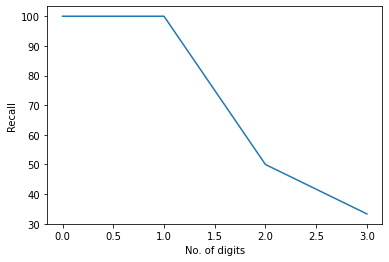

In [6]:
c = 0
d = 10+time_dur[c]//1000
predictions = []
spike_list = [0,0,0,0,0,0,0,0,0,0]
for z in range(len(S2.t/ms)):
    if(S2.t[z]/ms>d and S2.t[z]/ms<d+10+time_dur[c]//1000):
        spike_list[S2.i[z]]+=1
    elif(S2.t[z]/ms>d+10+time_dur[c]//1000):
        d += 10+time_dur[c]//1000
        if(c<len(time_dur)-1):
            c += 1
        d += 10+time_dur[c]//1000
        predictions.append(np.argmax(spike_list))
        spike_list = [0,0,0,0,0,0,0,0,0,0]
predictions.append(np.argmax(spike_list))

tot_dig = 0
corr = 0
recall = [100]
for z in range(len(spike_digits)):
    if(predictions[z]==spike_digits[z]):
        corr += 1
    tot_dig += 1
    recall.append((100*corr)/tot_dig)

plot(recall)
xlabel('No. of digits')
ylabel('Recall');  

In [7]:
predictions

[2, 2, 0]

In [8]:
spike_digits

[2, 5, 7]

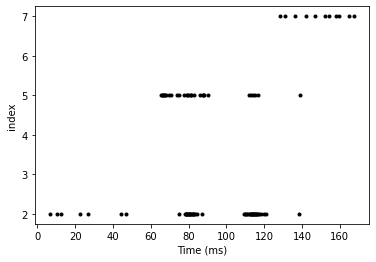

In [9]:
plot(S2.t/ms, S2.i, '.k')
xlabel('Time (ms)')
ylabel('index');

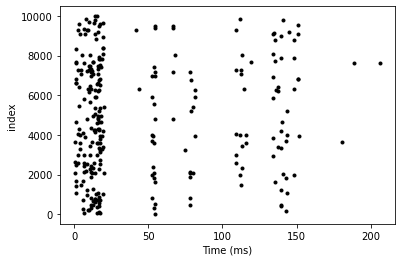

In [10]:
plot(S3.t/ms, S3.i, '.k')
xlabel('Time (ms)')
ylabel('index');

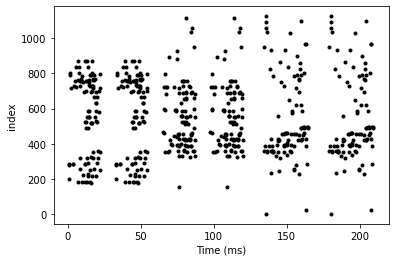

In [11]:
plot(S1.t/ms, S1.i, '.k')
xlabel('Time (ms)')
ylabel('index');